In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None )
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, f1_score, classification_report, make_scorer

from datetime import datetime

rd = np.random.seed(1973)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

In [4]:
df_train.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
3,3,0.00,0.00,0.00,30,31,31,94.62,138.82,129.23,57.54,93.08,79.73,48.03,110.00,90.96,0.00,0.00,0.00,0.00,0.00,0.00,8.54,2.36,39.03,26.71,71.78,77.13,0.00,0.26,2.94,0.00,0.00,0.00,35.26,74.41,119.12,48.99,90.71,40.69,21.31,37.93,10.88,0.00,0.00,0.00,0.00,0.00,0.00,70.31,128.64,51.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,105.58,203.06,170.69,6.21,3.33,15.78,7.24,18.01,41.99,0.00,0.00,0.00,13.46,21.34,57.78,1.11,23.53,1.48,0.00,2.56,13.03,0.00,0.00,0.00,0.00,0.00,0.00,1.11,26.09,14.51,14.96,76.58,72.29,0.00,0.00,0.00,0.00,29.13,0.00,0.38,0.00,0.00,3,2,5,120,120,310,120,120,130,6/20/2014,7/16/2014,8/26/2014,120,0,130,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,389,0.00,0.00,0.00,0
6,6,0.00,0.00,0.00,30,31,31,139.13,183.02,225.31,57.96,45.86,62.86,170.83,213.25,167.69,0.00,0.00,0.00,0.00,0.00,0.00,57.96,45.86,62.86,124.48,116.79,146.06,7.28,2.85,3.38,0.00,0.00,0.00,189.73,165.51,212.25,0.00,0.00,0.00,0.00,0.00,1.35,39.06,93.59,16.06,0.00,0.00,0.00,39.06,93.59,17.41,0.00,0.00,0.28,0.00,0.00,0.55,0.00,0.00,0.00,228.79,259.11,230.56,47.24,68.09,61.09,71.31,122.88,171.34,21.64,27.03,53.61,140.21,218.01,286.06,0.00,0.00,0.00,0.00,0.00,1.53,1.18,4.68,3.54,0.00,0.00,0.00,1.18,4.68,5.08,141.48,222.69,291.21,0.00,0.00,0.00,0.08,0.00,0.06,0.00,0.00,0.00,2,2,3,158,140,371,128,110,144,6/22/2014,7/31/2014,8/26/2014,1

In [5]:
#df_train.info(verbose=True, memory_usage='deep')

In [6]:
feats_object = df_train.select_dtypes('object').columns.to_list()

train = df_train.copy()
test = df_test.copy()

In [7]:
feats_object

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [8]:
for feat in feats_object:
    train[feat] = pd.to_datetime(train[feat], format="%m/%d/%Y")
    test[feat] = pd.to_datetime(test[feat], format="%m/%d/%Y")

In [60]:
train['date_of_last_rech_6_year'] = train['date_of_last_rech_6'].apply(lambda x: x.year)
train['date_of_last_rech_7_year'] = train['date_of_last_rech_7'].apply(lambda x: x.year)
train['date_of_last_rech_8_year'] = train['date_of_last_rech_8'].apply(lambda x: x.year)

train['date_of_last_rech_6_month'] = train['date_of_last_rech_6'].apply(lambda x: x.month)
train['date_of_last_rech_7_month'] = train['date_of_last_rech_7'].apply(lambda x: x.month)
train['date_of_last_rech_8_month'] = train['date_of_last_rech_8'].apply(lambda x: x.month)

train['date_of_last_rech_6_day'] = train['date_of_last_rech_6'].apply(lambda x: x.day)
train['date_of_last_rech_7_day'] = train['date_of_last_rech_7'].apply(lambda x: x.day)
train['date_of_last_rech_8_day'] = train['date_of_last_rech_8'].apply(lambda x: x.day)

test['date_of_last_rech_6_year'] = test['date_of_last_rech_6'].apply(lambda x: x.year)
test['date_of_last_rech_7_year'] = test['date_of_last_rech_7'].apply(lambda x: x.year)
test['date_of_last_rech_8_year'] = test['date_of_last_rech_8'].apply(lambda x: x.year)

test['date_of_last_rech_6_month'] = test['date_of_last_rech_6'].apply(lambda x: x.month)
test['date_of_last_rech_7_month'] = test['date_of_last_rech_7'].apply(lambda x: x.month)
test['date_of_last_rech_8_month'] = test['date_of_last_rech_8'].apply(lambda x: x.month)

test['date_of_last_rech_6_day'] = test['date_of_last_rech_6'].apply(lambda x: x.day)
test['date_of_last_rech_7_day'] = test['date_of_last_rech_7'].apply(lambda x: x.day)
test['date_of_last_rech_8_day'] = test['date_of_last_rech_8'].apply(lambda x: x.day)

feats_to_ignore = [x for x in train.columns.to_list() if train[x].nunique() == 1  ]
feats_to_ignore = (feats_to_ignore + ['id'] + feats_object)

feats = [x for x in train.columns.to_list() if x not in feats_to_ignore]
feats_X = feats.copy()
feats.remove('churn_probability')
feats.append('churn_probability')
feats_X.remove('churn_probability')

In [61]:
feats

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [62]:
feats_X

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

### fillna() for train and test

In [63]:
# train
# list of feats with NaNs
feats_nan_train = [ x[0] for x in train[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]

# only feats with 'arpu' has NaN
feats_arpu_train = [x for x in train[feats_nan_train].columns.to_list() if 'arpu' in x]
train.fillna(-2, inplace=True)

#test 
# list of feats with NaNs
feats_nan_test = [ x[0] for x in test[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]

# only feats with 'arpu' has NaN
feats_arpu_test = [x for x in test[feats_nan_test].columns.to_list() if 'arpu' in x]
test.fillna(-1, inplace=True)

In [64]:
# train[feats].hist(figsize=(60,50), bins=50);

In [65]:
# train['arpu_avg'] = (train['arpu_6'] + train['arpu_7'] + train['arpu_8']) / 3
# test['arpu_avg'] = (test['arpu_6'] + test['arpu_7'] + test['arpu_8']) / 3

# feats = feats + ['arpu_avg']
# feats_X = feats_X + ['arpu_avg']

# X_train = train[feats]
# X_test = test[feats_X]

In [66]:
train[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]] = train[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]].astype(float)
test[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]] = test[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]].astype(float)

In [67]:
# Compute the Average total recharge amount of each customer in 6 and 7 month 

Total_recharge_amount_6 = train["total_rech_amt_6"] + (train["av_rech_amt_data_6"] / 100) * train["total_rech_data_6"]

Total_recharge_amount_7 = train["total_rech_amt_7"] + (train["av_rech_amt_data_7"] / 100) * train["total_rech_data_7"]

Total_recharge_amount_8 = train["total_rech_amt_8"] + (train["av_rech_amt_data_8"] / 100)* train["total_rech_data_8"]

Total_recharge_amount_6and7 = Total_recharge_amount_6 + Total_recharge_amount_7

Avg_recharge_amount_6and7 = Total_recharge_amount_6and7 / 2

In [68]:
train['Total_recharge_amount_6'] = Total_recharge_amount_6
train['Total_recharge_amount_7'] = Total_recharge_amount_7
train['Total_recharge_amount_8'] = Total_recharge_amount_8

train['Avg_recharge_amount_6and7'] = Avg_recharge_amount_6and7 

In [69]:
np.percentile(Avg_recharge_amount_6and7, 80)

484.03999999955295

In [72]:
train['top_80'] = train['Avg_recharge_amount_6and7'].apply(lambda x: 1 if x  > 484 else 0)
train['top_80']

3        0
6        0
8        0
10       0
11       0
        ..
69987    1
69993    0
69994    1
69997    0
69998    0
Name: top_80, Length: 34999, dtype: int64

In [73]:
# Compute the Average total recharge amount of each customer in 6 and 7 month 

Total_recharge_amount_6 = test["total_rech_amt_6"] + (test["av_rech_amt_data_6"] / 100) * test["total_rech_data_6"]

Total_recharge_amount_7 = test["total_rech_amt_7"] + (test["av_rech_amt_data_7"] / 100) * test["total_rech_data_7"]

Total_recharge_amount_8 = test["total_rech_amt_8"] + (test["av_rech_amt_data_8"] / 100) * test["total_rech_data_8"]

Total_recharge_amount_6and7 = Total_recharge_amount_6 + Total_recharge_amount_7

Avg_recharge_amount_6and7 = Total_recharge_amount_6and7 / 2

In [74]:
test['Total_recharge_amount_6'] = Total_recharge_amount_6
test['Total_recharge_amount_7'] = Total_recharge_amount_7
test['Total_recharge_amount_8'] = Total_recharge_amount_8

test['Avg_recharge_amount_6and7'] = Avg_recharge_amount_6and7 

In [75]:
np.percentile(Avg_recharge_amount_6and7, 80)

489.50999999988824

In [76]:
test['top_80'] = test['Avg_recharge_amount_6and7'].apply(lambda x: 1 if x  > 489 else 0)
test['top_80']

0        0
1        0
2        1
4        0
5        0
        ..
69990    1
69991    0
69992    0
69995    0
69996    0
Name: top_80, Length: 35000, dtype: int64

In [80]:
feats = [
    "total_og_mou_8",
    "loc_ic_mou_8",
    "loc_og_mou_8",
    "aon",
    "roam_og_mou_8",
    "isd_ic_mou_6",
    "roam_ic_mou_8",
    "loc_og_t2f_mou_7",
    "std_ic_t2f_mou_7",
    "total_rech_amt_8",
    "max_rech_amt_8",
    "last_day_rch_amt_8",
    "sachet_2g_8",
    "count_rech_3g_8",
    "monthly_3g_8",
    "monthly_2g_8",
    "fb_user_6",
    "night_pck_user_8",
    "fb_user_8",
    "top_80",
    "churn_probability"
]

In [81]:
feats_X = [
    "total_og_mou_8",
    "loc_ic_mou_8",
    "loc_og_mou_8",
    "aon",
    "roam_og_mou_8",
    "isd_ic_mou_6",
    "roam_ic_mou_8",
    "loc_og_t2f_mou_7",
    "std_ic_t2f_mou_7",
    "total_rech_amt_8",
    "max_rech_amt_8",
    "last_day_rch_amt_8",
    "sachet_2g_8",
    "count_rech_3g_8",
    "monthly_3g_8",
    "monthly_2g_8",
    "fb_user_6",
    "night_pck_user_8",
    "fb_user_8",
    "top_80"
]

In [82]:
feats = feats + ['Total_recharge_amount_6', 'Total_recharge_amount_7', 'Total_recharge_amount_8', 'Avg_recharge_amount_6and7']
feats_X = feats_X + ['Total_recharge_amount_6', 'Total_recharge_amount_7', 'Total_recharge_amount_8', 'Avg_recharge_amount_6and7']

X_train = train[feats]
X_test = test[feats_X]

In [85]:
X_train.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,churn_probability,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
3,170.69,57.78,119.12,389,0.00,0.00,0.00,0.26,0.00,310,130,130,0,-2.00,0,0,-2.00,-2.00,-2.00,0,0,120.04,120.04,310.04,120.04
6,230.56,286.06,212.25,2456,0.00,0.08,0.00,2.85,4.68,371,144,130,0,-2.00,0,0,-2.00,-2.00,-2.00,0,0,158.04,140.04,371.04,149.04
8,241.46,139.96,25.58,537,6.55,0.00,0.00,0.00,0.00,563,98,50,2,0.00,0,0,-2.00,0.00,1.00,0,0,60.04,427.46,565.46,243.75
10,20.61,67.74,20.61,1477,0.00,0.28,0.00,0.00,37.36,30,30,0,0,-2.00,0,0,-2.00,-2.00,-2.00,0,0,60.04,60.04,30.04,60.04
11,386.79,499.66,353.00,2622,0.00,0.00,0.00,4.09,11.98,634,325,325,0,1.00,1,0,1.00,0.00,1.00,0,0,400.79,374.52,635.79,387.65


In [86]:
X_test.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,362.13,164.18,284.75,302,0.00,0.00,0.00,0.43,0.00,724,154,130,0,0.00,0,1,-1.00,0.00,1.00,0,0.01,374.92,725.54,187.47
1,107.29,168.33,100.00,634,0.00,0.00,0.00,0.00,1.11,285,130,130,0,-1.00,0,0,-1.00,-1.00,-1.00,0,230.01,220.01,285.01,225.01
2,453.89,231.51,434.50,1133,0.00,0.00,0.00,0.00,0.00,533,50,20,0,-1.00,0,0,-1.00,-1.00,-1.00,1,"1,156.01",535.25,533.01,845.63
4,106.53,136.91,43.12,498,0.00,0.00,0.00,0.00,0.00,481,30,25,8,8.00,0,0,1.00,0.00,1.00,0,153.13,80.01,543.09,116.57
5,0.00,-1.00,-1.00,1989,-1.00,0.00,-1.00,0.00,0.00,0,0,0,0,-1.00,0,0,-1.00,-1.00,-1.00,0,350.01,0.01,0.01,175.01


In [87]:
r = X_test.index[np.isinf(X_test).any(1)]
print(r)

Int64Index([], dtype='int64')


In [88]:
np.isinf(X_test).values.sum()

0

### normalization

In [89]:
from sklearn.preprocessing import RobustScaler

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
train_robust = pd.DataFrame(scaler.fit_transform(train[feats_X]), columns=feats_X)

train_robust.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.10,-0.15,0.42,-0.35,0.00,0.00,0.00,0.14,0.00,0.24,0.28,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.34,-0.30,0.24,-0.36
1,0.28,1.17,1.06,1.18,0.00,0.08,0.00,1.50,4.68,0.42,0.40,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.22,-0.24,0.41,-0.27
2,0.31,0.32,-0.21,-0.25,6.55,0.00,0.00,0.00,0.00,0.97,0.00,0.15,2.00,1.00,0.00,0.00,0.00,1.00,1.50,0.00,-0.52,0.63,0.97,0.04
3,-0.35,-0.09,-0.25,0.45,0.00,0.28,0.00,0.00,37.36,-0.56,-0.60,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.52,-0.48,-0.56,-0.56
4,0.74,2.40,2.01,1.30,0.00,0.00,0.00,2.15,11.98,1.18,1.99,2.27,0.00,1.50,1.00,0.00,1.50,1.00,1.50,0.00,0.52,0.47,1.17,0.52


In [90]:
# transform the test data
test_robust = pd.DataFrame(scaler.transform(test[feats_X]), columns=feats_X)

test_robust.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.67,0.46,1.55,-0.42,0.00,0.00,0.00,0.23,0.00,1.44,0.49,0.77,0.00,1.00,0.00,1.00,0.50,1.00,1.50,0.00,-0.70,0.47,1.43,-0.14
1,-0.09,0.49,0.29,-0.17,0.00,0.00,0.00,0.00,1.11,0.17,0.28,0.77,0.00,0.50,0.00,0.00,0.50,0.50,0.50,0.00,-0.00,-0.00,0.17,-0.02
2,0.95,0.85,2.57,0.20,0.00,0.00,0.00,0.00,0.00,0.89,-0.42,-0.08,0.00,0.50,0.00,0.00,0.50,0.50,0.50,1.00,2.83,0.96,0.88,2.02
3,-0.09,0.31,-0.09,-0.27,0.00,0.00,0.00,0.00,0.00,0.74,-0.60,-0.04,8.00,5.00,0.00,0.00,1.50,1.00,1.50,0.00,-0.24,-0.42,0.91,-0.37
4,-0.41,-0.49,-0.39,0.83,-1.00,0.00,-1.00,0.00,0.00,-0.65,-0.86,-0.23,0.00,0.50,0.00,0.00,0.50,0.50,0.50,0.00,0.37,-0.67,-0.65,-0.18


In [91]:
# train_robust.hist(figsize=(60,50), bins=50);

### transformation

In [92]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method = 'yeo-johnson')

'''
parameters:
method = 'box-cox' or 'yeo-johnson'
'''

train_transf = pd.DataFrame(scaler.fit_transform(train_robust), columns=feats_X)
train_transf.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.10,-0.36,0.58,-1.04,-0.06,-0.08,-0.05,-0.21,-0.11,0.37,0.58,1.24,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-0.62,-0.58,0.37,-0.75
1,0.38,1.14,1.09,1.29,-0.06,-0.02,-0.05,0.73,1.36,0.57,0.71,1.24,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-0.37,-0.45,0.56,-0.53
2,0.42,0.46,-0.64,-0.70,1.17,-0.08,-0.05,-0.39,-0.11,1.03,0.25,0.37,2.48,1.63,-0.26,-0.28,-0.58,1.66,1.68,-0.50,-1.07,0.74,1.03,0.07
3,-1.09,-0.23,-0.75,0.62,-0.06,0.11,-0.05,-0.39,2.83,-1.25,-0.84,-1.08,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-1.07,-1.03,-1.25,-1.29
4,0.86,1.60,1.47,1.37,-0.06,-0.08,-0.05,0.96,2.01,1.17,1.69,1.83,-0.41,1.72,3.90,-0.28,1.74,1.66,1.68,-0.50,0.65,0.59,1.16,0.65


In [93]:
# train_transf.hist(figsize=(60,50), bins=50);

In [94]:
test_transf = pd.DataFrame(scaler.transform(test_robust), columns=feats_X)
test_transf.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.80,0.62,1.32,-1.25,-0.06,-0.08,-0.05,-0.11,-0.11,1.31,0.79,1.24,-0.41,1.63,-0.26,3.54,1.33,1.66,1.68,-0.50,-1.59,0.59,1.31,-0.26
1,-0.30,0.64,0.42,-0.51,-0.06,-0.08,-0.05,-0.39,0.54,0.28,0.58,1.24,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,-0.50,0.02,0.00,0.27,-0.03
2,1.00,0.95,1.60,0.26,-0.06,-0.08,-0.05,-0.39,-0.11,0.97,-0.47,-0.35,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,2.00,1.81,0.99,0.97,1.55
3,-0.31,0.44,-0.30,-0.79,-0.06,-0.08,-0.05,-0.39,-0.11,0.86,-0.84,-0.20,2.49,1.78,-0.26,-0.28,1.74,1.66,1.68,-0.50,-0.40,-0.87,0.99,-0.78
4,-1.32,-1.40,-1.28,1.02,-1.21,-0.08,-1.23,-0.39,-0.11,-1.51,-1.49,-1.08,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,-0.50,0.49,-1.56,-1.51,-0.34


### X_train, y_train, X_test

In [95]:
train_transf.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.10,-0.36,0.58,-1.04,-0.06,-0.08,-0.05,-0.21,-0.11,0.37,0.58,1.24,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-0.62,-0.58,0.37,-0.75
1,0.38,1.14,1.09,1.29,-0.06,-0.02,-0.05,0.73,1.36,0.57,0.71,1.24,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-0.37,-0.45,0.56,-0.53
2,0.42,0.46,-0.64,-0.70,1.17,-0.08,-0.05,-0.39,-0.11,1.03,0.25,0.37,2.48,1.63,-0.26,-0.28,-0.58,1.66,1.68,-0.50,-1.07,0.74,1.03,0.07
3,-1.09,-0.23,-0.75,0.62,-0.06,0.11,-0.05,-0.39,2.83,-1.25,-0.84,-1.08,-0.41,-0.60,-0.26,-0.28,-0.58,-0.60,-0.60,-0.50,-1.07,-1.03,-1.25,-1.29
4,0.86,1.60,1.47,1.37,-0.06,-0.08,-0.05,0.96,2.01,1.17,1.69,1.83,-0.41,1.72,3.90,-0.28,1.74,1.66,1.68,-0.50,0.65,0.59,1.16,0.65


In [96]:
train_transf.shape

(34999, 24)

In [97]:
test_transf.head()

,total_og_mou_8,loc_ic_mou_8,loc_og_mou_8,aon,roam_og_mou_8,isd_ic_mou_6,roam_ic_mou_8,loc_og_t2f_mou_7,std_ic_t2f_mou_7,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,sachet_2g_8,count_rech_3g_8,monthly_3g_8,monthly_2g_8,fb_user_6,night_pck_user_8,fb_user_8,top_80,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,0.80,0.62,1.32,-1.25,-0.06,-0.08,-0.05,-0.11,-0.11,1.31,0.79,1.24,-0.41,1.63,-0.26,3.54,1.33,1.66,1.68,-0.50,-1.59,0.59,1.31,-0.26
1,-0.30,0.64,0.42,-0.51,-0.06,-0.08,-0.05,-0.39,0.54,0.28,0.58,1.24,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,-0.50,0.02,0.00,0.27,-0.03
2,1.00,0.95,1.60,0.26,-0.06,-0.08,-0.05,-0.39,-0.11,0.97,-0.47,-0.35,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,2.00,1.81,0.99,0.97,1.55
3,-0.31,0.44,-0.30,-0.79,-0.06,-0.08,-0.05,-0.39,-0.11,0.86,-0.84,-0.20,2.49,1.78,-0.26,-0.28,1.74,1.66,1.68,-0.50,-0.40,-0.87,0.99,-0.78
4,-1.32,-1.40,-1.28,1.02,-1.21,-0.08,-1.23,-0.39,-0.11,-1.51,-1.49,-1.08,-0.41,1.30,-0.26,-0.28,1.33,1.41,1.23,-0.50,0.49,-1.56,-1.51,-0.34


In [98]:
test_transf.shape

(35000, 24)

In [99]:
X_train = train_transf.values
y_train = train["churn_probability"].values

X_test  = test_transf.values 

### cal_metrics

In [100]:
def cal_metrics(y_test, y_pred):
    return {
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": fbeta_score(y_test, y_pred, beta=1.0),
        "f1.5": fbeta_score(y_test, y_pred, beta=1.5),
    }

### custom scorer

In [101]:
f_b1_5_scorer = make_scorer(fbeta_score, beta=1.5)

### cv = StratifiedKFold

In [102]:
cv = StratifiedKFold(n_splits=3)
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

# scores_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
# print("precision :", np.mean(scores_prec), np.std(scores_prec))

# scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
# print("recall :", np.mean(scores_recall), np.std(scores_recall))

# scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
# print("f1 :", np.mean(scores_f1), np.std(scores_f1))

scores_fb1_5 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f_b1_5_scorer)
print("f1.5 :", np.mean(scores_fb1_5), np.std(scores_fb1_5))


f1.5 : 0.6349916365512976 0.002766046104649665


fbeta_1.5: 0.63


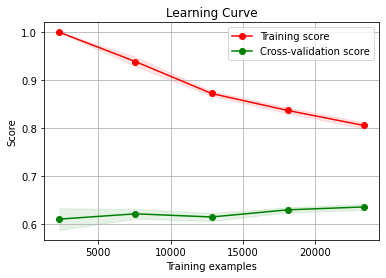

In [103]:
cv = StratifiedKFold(n_splits=3)

model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

def custom_score_cv(model, cv=cv, beta=1.5):
       
    f_beta_scorer = make_scorer(fbeta_score, beta=beta)
    
#     scores_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
#     scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
#     scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    scores_fbeta = cross_val_score(model, X_train, y_train, cv=cv, scoring=f_beta_scorer)

#     prec = np.mean(scores_prec)
#     print("Precision: {:,.2f}".format(prec))
    
#     recall = np.mean(scores_recall)
#     print("Recall: {:,.2f}".format(recall))
    
#     f1 = np.mean(scores_f1)
#     print("f1: {:,.2f}".format(f1))
    
    f_beta = np.mean(scores_fbeta)
    print("fbeta_{}: {:,.2f}".format(beta, f_beta))
       
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring=f_beta_scorer, random_state=rd)
    
    return None

custom_score_cv(model=model, cv=cv, beta=1.5)

In [43]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

0    32360
1     2640
Name: churn_probability, dtype: int64

### scale_pos_weight ==> XGBoost

In [104]:
scale_pos_weights = int(df_train["churn_probability"].value_counts()[0] / df_train["churn_probability"].value_counts()[1])
scale_pos_weights

8

In [105]:
f_b1_5_scorer = make_scorer(fbeta_score, beta=1.5)

cv = StratifiedKFold(n_splits=3)

model_pos = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, scale_pos_weight=scale_pos_weights, random_state=rd)

scores = cross_val_score(model_pos, X_train, y_train, cv=cv, scoring=f_b1_5_scorer)

np.mean(scores), np.std(scores)

(0.6833893101823842, 0.007803551351433292)

### model fit and predict

In [46]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

0    32360
1     2640
Name: churn_probability, dtype: int64

In [47]:
## model z scale_pos_weights 

model_pos = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, scale_pos_weight=8, random_state=rd)

model_pos.fit(X_train, y_train)

y_pred = model_pos.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

0    29707
1     5293
Name: churn_probability, dtype: int64

In [ ]:
df_test[ ["id", "churn_probability"] ].to_csv("../output/xgb_dummy2.csv", index=False)

### experiments

In [48]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

In [49]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3):    
     
    X_train = train[feats_X].values
    y_train = train["churn_probability"].values
    
    f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)                                 #shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = fbeta_score(y_train[test_idx], y_pred, beta=1.5)
#         score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring=f1_5_scorer, random_state=rd)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10478
           1       0.73      0.61      0.67      1189

    accuracy                           0.94     11667
   macro avg       0.85      0.79      0.82     11667
weighted avg       0.93      0.94      0.94     11667

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10478
           1       0.74      0.60      0.67      1188

    accuracy                           0.94     11666
   macro avg       0.85      0.79      0.82     11666
weighted avg       0.93      0.94      0.94     11666

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10477
           1       0.76      0.61      0.68      1189

    accuracy                           0.94     11666
   macro avg       0.86      0.79      0.82     11666
weighted avg       0.94      0.94      0.94     11666

Score:  0.645510711

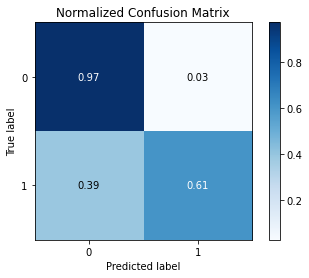

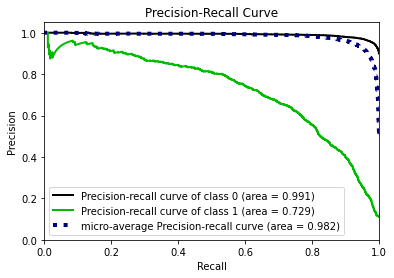

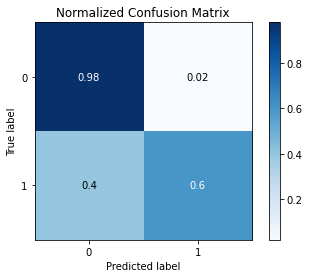

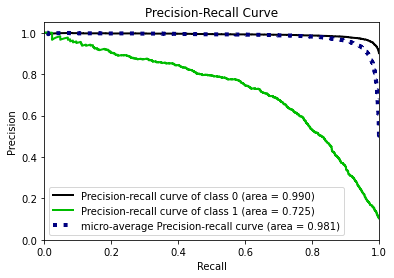

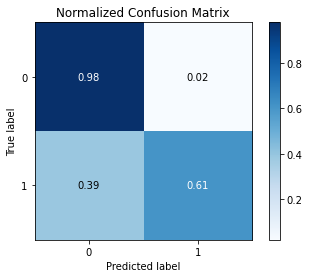

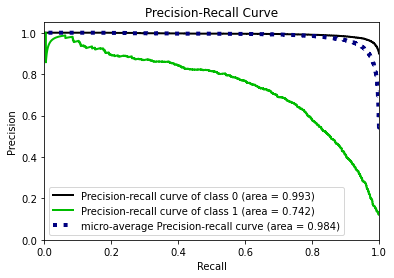

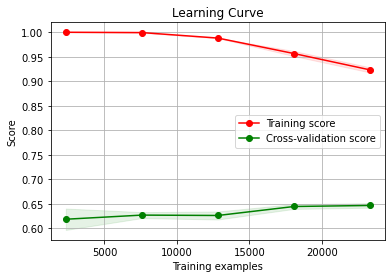

In [49]:
model = model
make_experiment(model)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10478
           1       0.59      0.75      0.66      1189

    accuracy                           0.92     11667
   macro avg       0.78      0.85      0.81     11667
weighted avg       0.93      0.92      0.93     11667

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10478
           1       0.60      0.74      0.67      1188

    accuracy                           0.92     11666
   macro avg       0.79      0.84      0.81     11666
weighted avg       0.93      0.92      0.93     11666

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10477
           1       0.60      0.75      0.66      1189

    accuracy                           0.92     11666
   macro avg       0.78      0.85      0.81     11666
weighted avg       0.93      0.92      0.93     11666

Score:  0.695486893

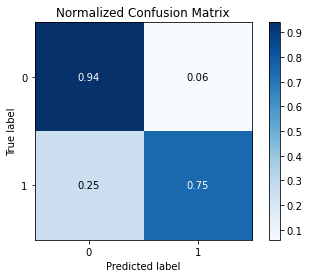

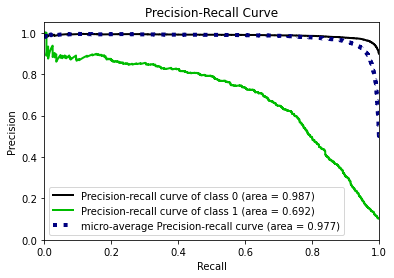

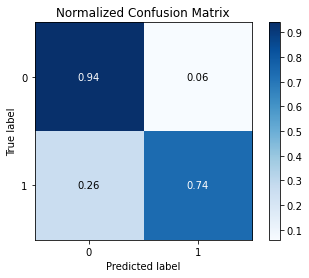

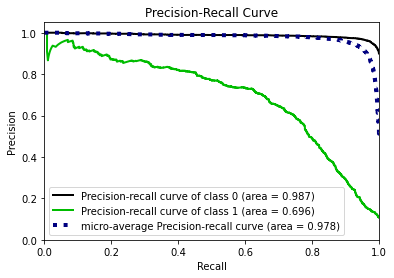

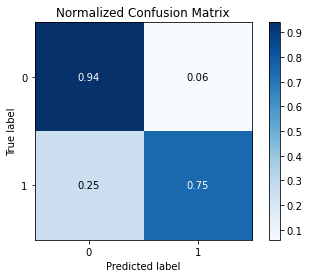

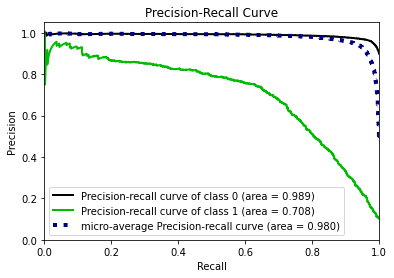

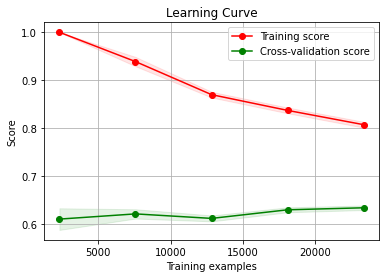

In [50]:
make_experiment(model, threshold=0.2 )

In [107]:
X_test

array([[ 0.80164479,  0.61630449,  1.31508301, ...,  0.59353883,
         1.30701844, -0.25915806],
       [-0.29950972,  0.64073756,  0.41860864, ...,  0.00478116,
         0.27282257, -0.03253905],
       [ 1.00228662,  0.94711742,  1.60002279, ...,  0.99066891,
         0.96828481,  1.54982279],
       ...,
       [-1.32396359, -1.10299138, -1.25192035, ..., -0.88954678,
        -0.31441761, -0.99806014],
       [-1.31110123, -0.82995393, -1.23468638, ...,  0.56662332,
        -1.50748205,  0.40129508],
       [-1.32396359, -1.39721012, -1.27904413, ..., -0.58248032,
        -1.50748205, -1.14920319]])

In [110]:
model_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=1973)
model_xgb.fit(X_train, y_train)

df_test["churn_probability"] = (model_xgb.predict_proba(X_test)[:,1] > 0.2).astype(np.int)

df_test[ ["id", "churn_probability"] ].to_csv("../output/xgb_threshold_0.2.csv", index=False)

In [111]:
model_ctb = ctb.CatBoostClassifier(depth=5, n_estimators=500, learning_rate=0.01, random_state=1973, verbose= False)
model_ctb.fit(X_train, y_train)

df_test["churn_probability"] = (model_ctb.predict_proba(X_test)[:,1] > 0.2).astype(np.int)

df_test[ ["id", "churn_probability"] ].to_csv("../output/cat_threshold_0.2.csv", index=False)

In [112]:
model_lgb = lgb.LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=1973)
model_lgb.fit(X_train, y_train)

df_test["churn_probability"] = (model_lgb.predict_proba(X_test)[:,1] > 0.2).astype(np.int)

df_test[ ["id", "churn_probability"] ].to_csv("../output/lgb_threshold_0.2.csv", index=False)

In [115]:
xgb_output = pd.read_csv("../output/xgb_threshold_0.2.csv")
lgb_output = pd.read_csv("../output/lgb_threshold_0.2.csv")
ctb_output = pd.read_csv("../output/cat_threshold_0.2.csv")

(0.33*xgb_output["churn_probability"] + 0.34*lgb_output["churn_probability"] + 0.33*ctb_output["churn_probability"]).value_counts()

0.00    30724
1.00     3387
0.67      568
0.33      209
0.34       98
0.66       14
Name: churn_probability, dtype: int64

In [116]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["churn_probability"] = ((0.33*xgb_output["churn_probability"] + 0.34*lgb_output["churn_probability"] + 0.33*ctb_output["churn_probability"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb_0.34lgb_0.33ctb.csv", index=False)